<a href="https://colab.research.google.com/github/pkw4885/school/blob/main/%EB%B0%95%EA%B1%B4%EC%9A%B0_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !apt-get update -qq # 나눔고딕 설치
# !apt-get install fonts-nanum* -qq

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# plt.rc('font', family='NanumBarunGothic')
# mpl.font_manager._rebuild()

#메캅 설치

In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 90
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 31.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-09 06:25:40--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c5:2ef4, ...
Connecti

초기 세팅

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer #텐서플로우도 사용해보았습니다.
from tensorflow.keras.preprocessing.sequence import pad_sequences 

데이터 로드 (github 참조, 네이버 쇼핑 리뷰)

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")


('ratings_total.txt', <http.client.HTTPMessage at 0x7f1ea11ac090>)

In [5]:
td = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(td)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [6]:
td = td[:10000]
#20만으로 실험결과 너무 긴 시간으로 인해 1만으로 축소

5    3995
2    3223
1    1799
4     983
Name: ratings, dtype: int64


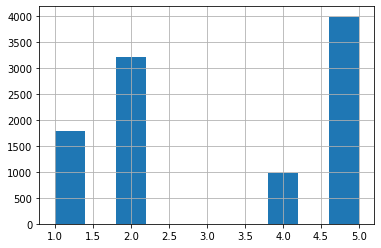

In [7]:
print(td['ratings'].value_counts())
td['ratings'].hist()

In [8]:
td.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [9]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환

def rating_to_label(ratings):
    if ratings > 3:
        return 1
    else:
        return 0
    
td['y'] = td['ratings'].apply(lambda x: rating_to_label(x))

In [10]:
td["y"].value_counts()

0    5022
1    4978
Name: y, dtype: int64

한국어 텍스트 전처리


In [11]:
# 한글 불용어 사전 다운
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
# stopwords[:10]
# 형태 조정, 특별한 용어 추가 불용어 
stopwords=[x[0]  for x in stopwords]
stopwords[:10]

['휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해']

In [12]:
import konlpy
# tagger = konlpy.tag.Mecab()
tagger = konlpy.tag.Okt()

tokens=[]
corpus =[]
# stopwords = ['(,', '것', '계','간의']

for i, sentence in enumerate(td['reviews']):
    para = tagger.nouns(sentence)
    para = [x for x in para if x not in stopwords] # 불용어 제거
    para = [x for x in para if len(x) > 1]
    tokens.append(para)
    corpus.append(' '.join(para))

print(corpus[:5])
print(tokens[:5])

['배공', '택배 엉망', '아주 바지 정말 구매 가격 대박 바느질 가성 최고', '선물 전달 상품 머그컵 당황 배송 누락 확인 선물 큰일 배송 다시 생각', '민트 색상 손잡이 도로 사용']
[['배공'], ['택배', '엉망'], ['아주', '바지', '정말', '구매', '가격', '대박', '바느질', '가성', '최고'], ['선물', '전달', '상품', '머그컵', '당황', '배송', '누락', '확인', '선물', '큰일', '배송', '다시', '생각'], ['민트', '색상', '손잡이', '도로', '사용']]


EDA

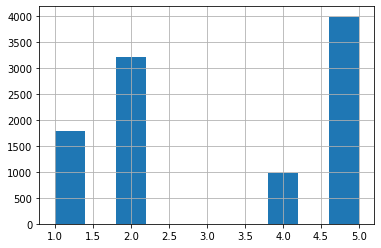

In [13]:
# 점수별 빈도수
td['ratings'].hist()

In [14]:
# print(td[:5])
# print(td.loc[td['y']==0,][:5])
tokens_p, tokens_n = [],[]
for i, token in enumerate(tokens):
  # if i>5:
  #   break
  if td['y'].values[i]== 1:  # 주의 : df['y'][i] 값을 사용하면 기존 index가 참조되어서 값이 다름
    tokens_p.append(token)
  else :
    tokens_n.append(token)

print(tokens_p)
print(tokens_n)

[['배공'], ['아주', '바지', '정말', '구매', '가격', '대박', '바느질', '가성', '최고'], ['민트', '색상', '손잡이', '도로', '사용'], ['사이즈'], ['촉감', '무게'], ['사이즈'], ['친구'], [], ['가게', '운영', '사장', '대신', '구매', '구매', '가게'], ['가성', '바퀴', '고정', '린데'], ['팽이', '배송'], ['생각'], ['옵션', '파우치', '구매', '사용'], ['선물', '사람', '사람'], ['고정', '처럼', '걱정'], ['주문', '카페'], ['색도', '이불'], ['네이비', '색상'], ['역시', '보람', '제품', '이군'], ['이유식', '초기', '사용', '후기', '보고', '구매', '사이즈', '실리콘', '재질'], ['사이즈'], ['저번', '삿는데', '역시', '핸들'], ['배송', '짱짱'], ['돌뼈', '최고'], ['가게', '사용'], ['사이즈', '구매', '프린트'], ['포인트'], ['보온', '기능', '최고', '강추'], ['접착', '그대로'], [], ['흰색', '아기', '재질'], ['항상', '애용', '리뷰', '기도', '배송'], ['아주', '밑위', '좀더'], ['수딩젤', '크림', '보습'], ['페넬로페', '세자', '제품', '구매', '세자', '마지막', '도착'], ['사이즈', '크게'], ['아주', '강추'], ['센치', '토퍼', '사용', '사이즈', '배송'], ['몇번'], ['두께', '생각', '갈색'], ['항상', '구매', '가격', '대비', '최고', '최공'], ['선물'], ['필수', '구매'], ['여유'], ['가성', '최고', '불도'], ['상품', '지인', '추천', '문해'], ['회사', '자주', '주문', '그냥', '배송'], ['설치', '화질'], ['아기', '목욕', '안전', '세면대', 

In [15]:
corpus_n, corpus_p = [], []
for token in tokens_p:
  corpus_p.append(' '.join(token))
for token in tokens_n:
  corpus_n.append(' '.join(token))
# 모든 리뷰를 긍정 부정 하나의 corpus로 합치기 
corpus_p1 = ' '.join(corpus_p).split()
corpus_n1 = ' '.join(corpus_n).split()
print(corpus_p1)

['배공', '아주', '바지', '정말', '구매', '가격', '대박', '바느질', '가성', '최고', '민트', '색상', '손잡이', '도로', '사용', '사이즈', '촉감', '무게', '사이즈', '친구', '가게', '운영', '사장', '대신', '구매', '구매', '가게', '가성', '바퀴', '고정', '린데', '팽이', '배송', '생각', '옵션', '파우치', '구매', '사용', '선물', '사람', '사람', '고정', '처럼', '걱정', '주문', '카페', '색도', '이불', '네이비', '색상', '역시', '보람', '제품', '이군', '이유식', '초기', '사용', '후기', '보고', '구매', '사이즈', '실리콘', '재질', '사이즈', '저번', '삿는데', '역시', '핸들', '배송', '짱짱', '돌뼈', '최고', '가게', '사용', '사이즈', '구매', '프린트', '포인트', '보온', '기능', '최고', '강추', '접착', '그대로', '흰색', '아기', '재질', '항상', '애용', '리뷰', '기도', '배송', '아주', '밑위', '좀더', '수딩젤', '크림', '보습', '페넬로페', '세자', '제품', '구매', '세자', '마지막', '도착', '사이즈', '크게', '아주', '강추', '센치', '토퍼', '사용', '사이즈', '배송', '몇번', '두께', '생각', '갈색', '항상', '구매', '가격', '대비', '최고', '최공', '선물', '필수', '구매', '여유', '가성', '최고', '불도', '상품', '지인', '추천', '문해', '회사', '자주', '주문', '그냥', '배송', '설치', '화질', '아기', '목욕', '안전', '세면대', '설치', '시트', '고정', '다리', '배송', '배송', '상품', '사진', '용량', '박스', '사이즈', '체크', '제품', '배송', '날짜', '이사', '배달'

In [16]:
from collections import Counter
counter_p = Counter(corpus_p1)
counter_n = Counter(corpus_n1)
print(counter_p.most_common(10))
print(counter_n.most_common(10))

[('배송', 788), ('구매', 466), ('사용', 346), ('가격', 317), ('제품', 262), ('주문', 251), ('생각', 218), ('아주', 189), ('사이즈', 186), ('정말', 160)]
[('배송', 625), ('그냥', 529), ('별로', 370), ('구매', 368), ('제품', 358), ('생각', 328), ('사용', 318), ('주문', 260), ('가격', 239), ('상품', 235)]


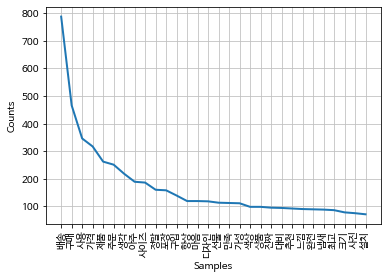

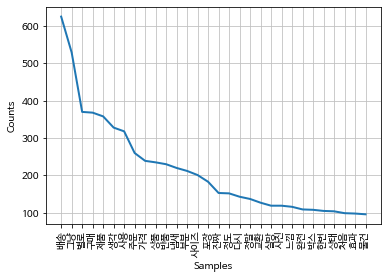

In [17]:
import nltk
import matplotlib.pyplot as plt
pos = nltk.Text(corpus_p1)
neg = nltk.Text(corpus_n1)
plt.rc('font', family='NanumBarunGothic') 

plt.figure(1)
pos.plot(30)

plt.figure(2)
neg.plot(30)
plt.show()

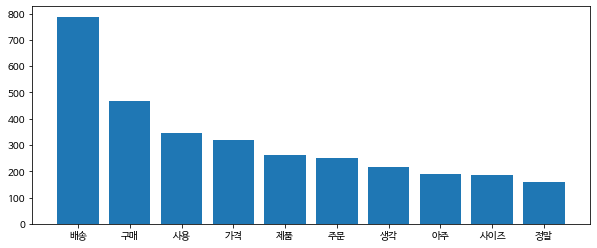

In [18]:
top_10 = counter_p.most_common(10)

plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(range(len(top_10)), [val[1] for val in top_10])
plt.xticks(range(len(top_10)), [val[0] for val in top_10])
plt.show()

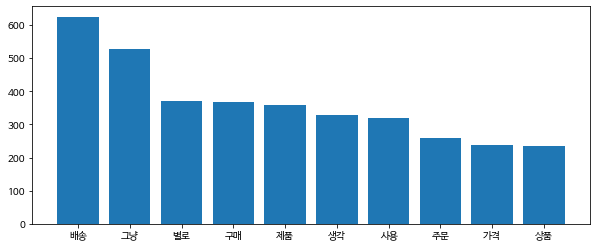

In [19]:
top_10 = counter_n.most_common(10)

plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(range(len(top_10)), [val[1] for val in top_10])
plt.xticks(range(len(top_10)), [val[0] for val in top_10])
plt.show()

DTM 구하기, corpus 문서단위

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
g_dictionary = gensim.corpora.Dictionary(tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
dtm = vector.fit_transform(corpus).toarray()
col = g_dictionary.token2id.keys()
print(dtm.shape)
pd.DataFrame(dtm, columns=col)

(10000, 6899)


,배공,엉망,택배,가격,가성,구매,대박,바느질,바지,아주,정말,최고,누락,다시,당황,머그컵,배송,상품,생각,선물,전달,큰일,확인,도로,민트,사용,색상,손잡이,계란,별로,보기,실용,완전,진짜,코팅,연락,전화,주문,추천,회사,...,하래,상하이,스벅,소꿉장난,모유수유,보리차,연달,물주,반제품,뱔로,낚아놓,덴탈,대기업,청정도,고구마줄기,기구,수지,고삿,란스,마수,사진빨,색칠,스킵,이만원,동남아,츠바키,캔버스,훨낫슴다,메세지,오기,주택가,항의,인라인스케이트,복대,갑갑,고향,미술관,눈뒤,실거,쑈는핟
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,1,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
9998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
TF-IDF 변환

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vectorizer = TfidfTransformer()
tf_idf = tfidf_vectorizer.fit_transform(dtm).toarray()
col = g_dictionary.token2id.keys()
print(tf_idf.shape)
pd.DataFrame(tf_idf, columns=col)

(10000, 6899)


,배공,엉망,택배,가격,가성,구매,대박,바느질,바지,아주,정말,최고,누락,다시,당황,머그컵,배송,상품,생각,선물,전달,큰일,확인,도로,민트,사용,색상,손잡이,계란,별로,보기,실용,완전,진짜,코팅,연락,전화,주문,추천,회사,...,하래,상하이,스벅,소꿉장난,모유수유,보리차,연달,물주,반제품,뱔로,낚아놓,덴탈,대기업,청정도,고구마줄기,기구,수지,고삿,란스,마수,사진빨,색칠,스킵,이만원,동남아,츠바키,캔버스,훨낫슴다,메세지,오기,주택가,항의,인라인스케이트,복대,갑갑,고향,미술관,눈뒤,실거,쑈는핟
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.759672,0.650306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.230399,0.316257,0.211679,0.411438,0.445559,0.404769,0.287043,0.269901,0.339422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317939,0.209093,0.307386,0.382626,0.256314,0.188276,0.165745,0.442497,0.328066,0.353519,0.239338,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523916,0.613241,0.245614,0.331292,0.423518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9996,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9997,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

변환 후 10000 rows × 6899 columns가 출력됩니다. 여기서

한 행(row)은 한 리뷰를 의미하고

한 열(column)은 한 단어를 의미합니다.

In [22]:
# id_to_word
print(vector.vocabulary_)
id_to_word = {v: k for k, v in vector.vocabulary_.items()}
print(id_to_word)
print(id_to_word[10])

{'배공': 0, '엉망': 1, '택배': 2, '가격': 3, '가성': 4, '구매': 5, '대박': 6, '바느질': 7, '바지': 8, '아주': 9, '정말': 10, '최고': 11, '누락': 12, '다시': 13, '당황': 14, '머그컵': 15, '배송': 16, '상품': 17, '생각': 18, '선물': 19, '전달': 20, '큰일': 21, '확인': 22, '도로': 23, '민트': 24, '사용': 25, '색상': 26, '손잡이': 27, '계란': 28, '별로': 29, '보기': 30, '실용': 31, '완전': 32, '진짜': 33, '코팅': 34, '연락': 35, '전화': 36, '주문': 37, '추천': 38, '회사': 39, '길이': 40, '계속': 41, '보폴': 42, '안나': 43, '지금': 44, '밴딩': 45, '밴딩부분': 46, '브랜드': 47, '빅사': 48, '속옷': 49, '신축': 50, '위생': 51, '이즈': 52, '일반': 53, '전문': 54, '팬티': 55, '사이즈': 56, '베이지': 57, '살색': 58, '그냥': 59, '컬러': 60, '화면': 61, '별루': 62, '탛캏타': 63, '무게': 64, '촉감': 65, '친구': 66, '실내': 67, '가게': 68, '대신': 69, '사장': 70, '운영': 71, '고정': 72, '린데': 73, '바퀴': 74, '거품': 75, '듯해': 76, '생기': 77, '정력': 78, '화장': 79, '남자': 80, '성분': 81, '유해': 82, '초등': 83, '결착': 84, '모서리': 85, '부분': 86, '불량': 87, '이슈': 88, '제품': 89, '채집': 90, '최소한': 91, '커터칼': 92, '테스트': 93, '해당': 94, '팽이': 95, '부직포': 96, '사서': 97, '산다': 98, '살껄':

로지스틱 회귀에 의한 감정분석

In [23]:
td.head()

,ratings,reviews,y
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [24]:
td["y"].value_counts()

0    5022
1    4978
Name: y, dtype: int64

In [25]:
X = tf_idf
y=td['y']
data = pd.concat([y,pd.DataFrame(X)], axis=1)
data

,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,6859,6860,6861,6862,6863,6864,6865,6866,6867,6868,6869,6870,6871,6872,6873,6874,6875,6876,6877,6878,6879,6880,6881,6882,6883,6884,6885,6886,6887,6888,6889,6890,6891,6892,6893,6894,6895,6896,6897,6898
0,1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0,0.0,0.759672,0.650306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,1,0.0,0.000000,0.000000,0.230399,0.316257,0.211679,0.411438,0.445559,0.404769,0.287043,0.269901,0.339422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317939,0.209093,0.307386,0.382626,0.256314,0.188276,0.165745,0.442497,0.328066,0.353519,0.239338,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523916,0.613241,0.245614,0.331292,0.423518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9996,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9997,0,0.0,0.000000,0.000000,0.000

In [26]:
from sklearn.model_selection import train_test_split

train_td,test_td = train_test_split(data, test_size = 0.3, random_state=256)
train_td.head()

,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,6859,6860,6861,6862,6863,6864,6865,6866,6867,6868,6869,6870,6871,6872,6873,6874,6875,6876,6877,6878,6879,6880,6881,6882,6883,6884,6885,6886,6887,6888,6889,6890,6891,6892,6893,6894,6895,6896,6897,6898
9498,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4773,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4705,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1904,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
x_train = train_td.drop(['y'], axis=1)
y_train = train_td['y']
x_test = test_td.drop(['y'], axis=1)
y_test = test_td['y']

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

In [29]:
a1 = accuracy_score(y_test, y_pred)
p1 = precision_score(y_test, y_pred)
r1 =recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print('accuracy: %.2f' % a1 )
print('precision: %.2f' % p1)
print('recall: %.2f' % r1)
print('F1: %.2f' % f1)

accuracy: 0.72
precision: 0.69
recall: 0.80
F1: 0.74


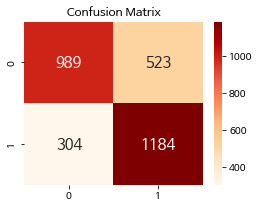

In [30]:
# confusion matrix, 데이터 불균형에 의한 과적합 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [31]:
#sampling 재조정
td['y'].value_counts()

0    5022
1    4978
Name: y, dtype: int64

In [32]:
# under-sampling 방법으로 불균형 해소 
positive_random_idx = td[td['y']==1].sample(275, random_state=12).index.tolist()
negative_random_idx = td[td['y']==0].sample(275, random_state=12).index.tolist()

In [33]:
random_idx = positive_random_idx + negative_random_idx
x = tf_idf[random_idx]
y = td['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [34]:
x_train.shape, y_train.shape

((412, 6899), (412,))

In [35]:
x_test.shape, y_test.shape

((138, 6899), (138,))

In [36]:
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
y_pred = lr2.predict(x_test)

In [37]:
# classification result for test set
a2 = accuracy_score(y_test, y_pred)
p2 = precision_score(y_test, y_pred)
r2 =recall_score(y_test, y_pred)
f2= f1_score(y_test, y_pred)
print('accuracy: %.2f' % a2 )
print('precision: %.2f' % p2)
print('recall: %.2f' % r2)
print('F1: %.2f' % f2)

accuracy: 0.65
precision: 0.63
recall: 0.71
F1: 0.67


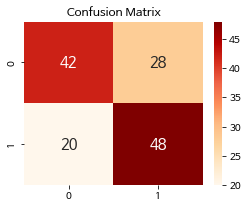

In [38]:
# 개선된 confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# 분류 정확도 test_result 
pd.options.display.float_format = '{:.2f}'.format
tr1 = pd.DataFrame([a1,p1,r1,f1])
tr2 = pd.DataFrame([a2,p2,r2,f2])

test_result = pd.concat([tr1.T, tr2.T], axis=0)
test_result.columns=['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1']
test_result.index = ['1차 Imbalance Data', '2차 Under-sampling']
test_result


,Accuracy(정확도),Precision(정밀도),Recall(재현율),F1
1차 Imbalance Data,0.72,0.69,0.80,0.74
2차 Under-sampling,0.65,0.63,0.71,0.67


In [40]:
# 긍정/부정 키워드 추출 긍 / 부정 키워드를 추출 coeficient를 시각화
lr2.coef_

array([[ 0.        , -0.46876973,  0.07870034, ...,  0.        ,
         0.        ,  0.        ]])

<BarContainer object of 6899 artists>

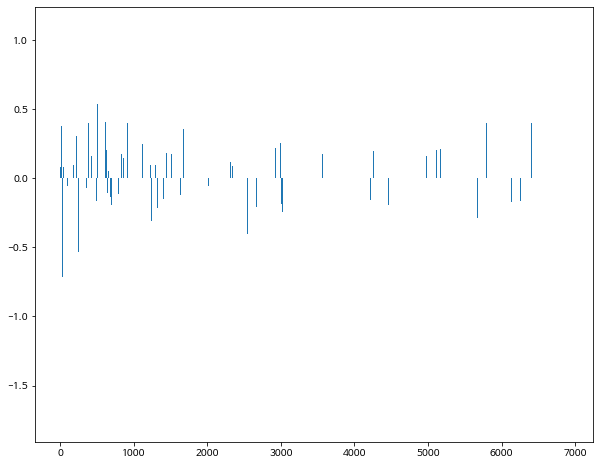

In [41]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

In [42]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(1.0971009533703633, 221), (1.0665023870636416, 9), (0.8522667208518696, 454), (0.8461850581842073, 19), (0.7890803355751883, 324)]
[(-0.713638299951507, 362), (-0.714440305984317, 29), (-0.7712293033063634, 241), (-0.8392367658667745, 110), (-1.76417456998824, 59)]


In [43]:
# 일부 중요 원소들 단어사전 확인
print('긍정리뷰 키워드: ', id_to_word[79],id_to_word[92]) 
print('부정리뷰 키워드: ', id_to_word[416],id_to_word[513]) 

긍정리뷰 키워드:  화장 커터칼
부정리뷰 키워드:  문의 쪼그마


In [44]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)
coef_pos_index

[(1.0971009533703633, 221),
 (1.0665023870636416, 9),
 (0.8522667208518696, 454),
 (0.8461850581842073, 19),
 (0.7890803355751883, 324),
 (0.7275352166092955, 11),
 (0.7074069752899314, 299),
 (0.6277273490616992, 3),
 (0.5520369745168067, 445),
 (0.5377814020977536, 505),
 (0.5296247438371678, 422),
 (0.5099414637696655, 222),
 (0.5073670889582251, 1118),
 (0.5042936207985185, 1410),
 (0.5025786662300308, 578),
 (0.48491598171683414, 364),
 (0.4795576360598821, 378),
 (0.47770856187471505, 251),
 (0.4481760118400144, 18),
 (0.44542071002446076, 167),
 (0.4276814194497673, 55),
 (0.4084326182233561, 614),
 (0.40823577918226445, 2484),
 (0.40167972333478763, 271),
 (0.40059019084800507, 6408),
 (0.40059019084800507, 5796),
 (0.40059019084800507, 4953),
 (0.40059019084800507, 4669),
 (0.40059019084800507, 3995),
 (0.40059019084800507, 3776),
 (0.40059019084800507, 3151),
 (0.40059019084800507, 2751),
 (0.40059019084800507, 2483),
 (0.40059019084800507, 913),
 (0.40059019084800507, 540),


In [45]:
#  index를 단어로 변환하여 "긍정 키워드 리스트"와 "부정 키워드 리스트"의 Top 20 단어를 출력
invert_index_vectorizer = id_to_word

In [46]:
pos_top_word=[] 
pos_top_score=[]
for coef in coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    pos_top_word.append(invert_index_vectorizer[coef[1]])
    pos_top_score.append(coef[0])

구입 1.0971009533703633
아주 1.0665023870636416
만족 0.8522667208518696
선물 0.8461850581842073
머리 0.7890803355751883
최고 0.7275352166092955
효과 0.7074069752899314
가격 0.6277273490616992
완료 0.5520369745168067
디자인 0.5377814020977536


In [47]:
neg_top_word=[] 
neg_top_score=[]

for coef in coef_neg_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    neg_top_word.append(invert_index_vectorizer[coef[1]])
    neg_top_score.append(coef[0])

그냥 -1.76417456998824
최악 -0.8392367658667745
실망 -0.7712293033063634
별로 -0.714440305984317
상태 -0.713638299951507
불량 -0.701585256456722
반품 -0.690568846434128
부분 -0.6861468147896973
도착 -0.6705729545105643
구멍 -0.6597778672916428


In [48]:
pos_top_word.reverse()
pos_top_score.reverse()
top_word=neg_top_word+ pos_top_word
top_score = neg_top_score+ pos_top_score

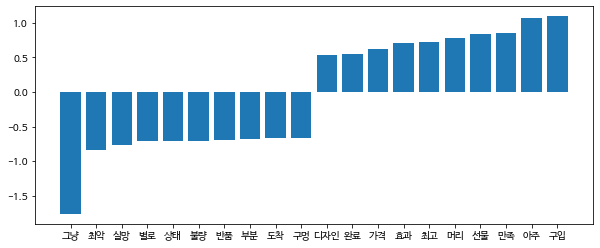

In [49]:
plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

plt.bar(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.bar(pos_top_word, pos_top_score, label = "긍정", color = 'g')

plt.bar(range(len(top_score)), top_score)
plt.xticks(range(len(top_word)), top_word)
plt.show()


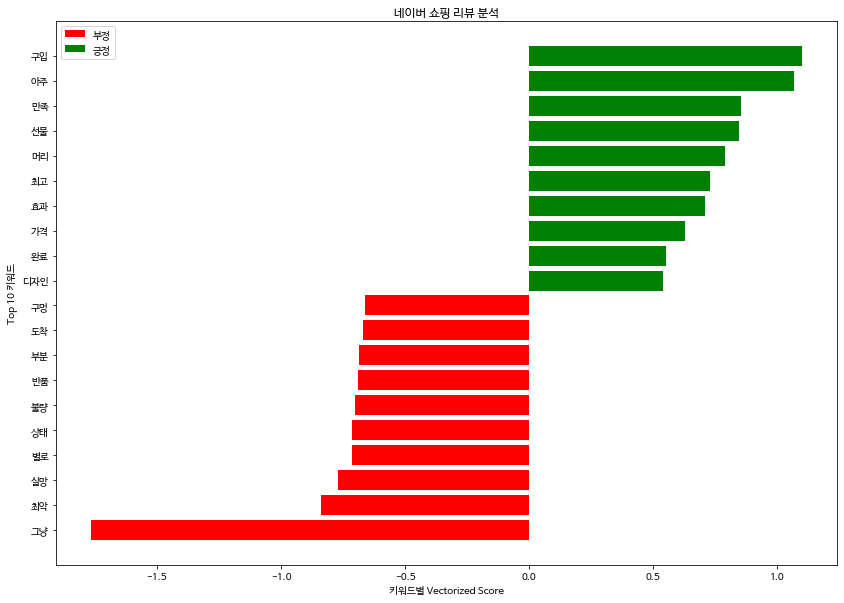

In [50]:
# 감정분석 결과 시각화 
import matplotlib.pyplot as plt
plt.figure(figsize=[14, 10])
plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
# Giving the tilte for the plot
plt.title('네이버 쇼핑 리뷰 분석')
# Saving the plot as a 'png'
plt.savefig('2BarPlot.png')
# Displaying the bar plot
plt.show()

Text(0.5, 0.98, 'Categorical Plotting')

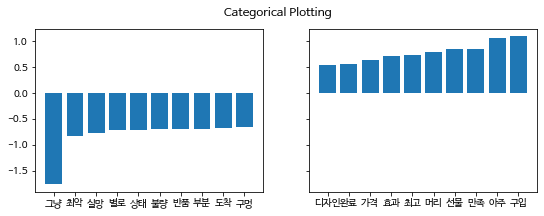

In [51]:
# 약간 다르게 시각화 
import matplotlib.pyplot as plt

data1 = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names1 = list(data1.keys())
values1 = list(data1.values())

data2 = {'apple': 1, 'orange': 5, 'lemon': 15, 'lime': 25}
names2 = list(data2.keys())
values2 = list(data2.values())

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(neg_top_word, neg_top_score)
axs[1].bar(pos_top_word, pos_top_score)
fig.suptitle('Categorical Plotting')

딥러닝(시도중)

In [52]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [53]:
import sentencepiece as spm
vocab = spm.SentencePieceProcessor()
from google.colab import drive
drive.mount('/content/drive/')

vocab.load(os.path.join('/content/drive/MyDrive/data', 'kowiki.model'))

td_2 = pd.read_csv('ratings_total.txt', names=['ratings', 'reviews'], delimiter = '\t')
td_2 = td_2[:20000]
td_2

Mounted at /content/drive/


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
19995,1,중간이 구겨져서 왔네요. 넓은데 붙이려고 샀는데 쓰지도 못해요.
19996,5,싸이즈가없어서 한치수큰걸샀는데 역시 편하고좋아요
19997,1,포장 상태보고 바로 반품했어야 했는데 귀찮네요 리뷰를 잘 봤어야 했는디
19998,1,유통기간 너무짧아요


In [54]:
train_length = td_2["reviews"].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

0     6
1    25
2    47
3    87
4    24
5    44
6    61
7    18
8    15
9    87
Name: reviews, dtype: int64

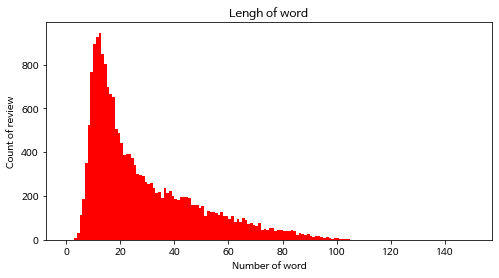

In [55]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=150, range=[0, 150], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [56]:
# 데이터 길이

print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     117
token 길이 최소:       2
token 길이 평균:      28.03
token 길이 표준편차:   19.79


In [57]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:    13.00
token 50/100분위:    21.00
token 75/100분위:    39.00
token IQR:          26.00
token MAX/100분위:   78.00


In [58]:
# 앞으로 패딩입력을 위한 표준 최대 토큰수 졀정 
n_seq = 65

In [59]:
id_to_label = {0: "부정", 1: "긍정"}

In [60]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환
def rating_to_label(ratings):
    if ratings > 3:
        return 1
    else:
        return 0
    
td_2['y'] = td_2['ratings'].apply(lambda x: rating_to_label(x))

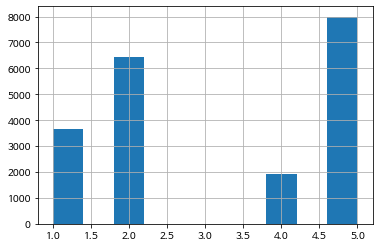

In [61]:
td_2['ratings'].hist()

0    10085
1     9915
Name: y, dtype: int64


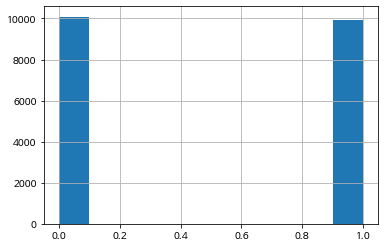

In [62]:
print(td_2['y'].value_counts())
td_2['y'].hist()

In [63]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df 입력 
from sklearn.model_selection import train_test_split
td_2_train,td_2_test = train_test_split(td_2, test_size = 0.3, random_state=256) # 1방안 
td_2_test = td_2_test.dropna()
td_2_test

,ratings,reviews,y
4414,1,이런 상품이 많지 않아서 그런지 드럽게 비싸네요. 가성비 떨어지나 대안이 없이 일단...,0
16821,1,빨자마자 원단이 이염됬어요,0
8563,1,냄새가 너무 납니다 일주일을 밖에 두었고 그래도 냄새가 안빠져서 탈취제를 반통을 뿌...,0
12302,1,재구매 배송비 지불한상품을 왜 같이보내 택배아저씨에게갈 배송비를 ..,0
3254,2,낚시가 잘 안됩니다 ㅠㅠ,0
...,...,...,...
835,2,만족따뜻해요..안에 피쓰쪽부셔져서달그닥소리나서 반품보낼려다가귀찮아서 다풀고 안에 플...,0
18169,5,매번시켜먹지만 그닥모르겠어 가격이 저렴했으면,1
628,1,재구매 다좋은데 배송에 다소 문제가있어요!,0
17771,2,일부러 면제품 골라 구매한건데 씸리스라 봉제선없어 눌리지 않을거라 생각했는데 접착된...,0


In [64]:
# under-sampling 방법으로 불균형 해소 : 550개 샘플만 적용하여 학습 및 평가 
positive_random_idx = td_2[td_2['y']==1].sample(3275, random_state=12).index.tolist()
negative_random_idx = td_2[td_2['y']==0].sample(3275, random_state=12).index.tolist()
random_idx = positive_random_idx + negative_random_idx
x = td_2['reviews'][random_idx]
y = td_2['y'][random_idx]
new_td_2 = pd.concat([y,x],axis=1)
new_td_2

,y,reviews
7659,1,맛있어요 저지방우유이지만 고소해서 아이들이 잘먹습니다 다른우유에는 지방권장량이 너무...
13897,1,아이들 장난감상자로 구입했는데요 완전한 흰색은 아니고 살짝 물이 섞인 흰색입니다. ...
1416,1,배송빠르고좋아요 항상먹이던게요
10337,1,가성비 좋아요. 지속력 괜찮아요.
18740,1,조금 새어나오긴 하지만 좋아요 잘썼어용
...,...,...
8813,0,검은색 중간중간 다비치고 2개에1개꼴로 끈이 떨어집니다 ㅡㅡ 개별포장따위도없구요
3838,0,아쉽습니다. 체리가 가공식품이 아니라서 이해는 하지만 크기도 그렇고 맛도ㅠㅠ 이제부...
17324,0,생각보다 만듬새가 부실해 보여요. 환불하기 귀찮아서 일단 사용합니다
15540,0,맛이없어요


In [65]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 td_2 적용,  2. undersampling으로 하면 new_df를 입력 
from sklearn.model_selection import train_test_split
td_2_train,td_2_test = train_test_split(new_td_2, test_size = 0.3, random_state=256) # 2방안 

td_2_test = td_2_test.dropna()
td_2_test  # 550개중 165개 test용 

,y,reviews
15379,1,저렴하게 잘 구입해서 잘 쓰고 있습니다. 가성비 좋습니다.
3346,0,제품 잘 받았습니다. 이왕이면 기본카메라와 업그레이드 카메라의 외형을 메인에 올려두...
19725,0,고기구매하면서 사봤습니다~그런데..흠...기름기도 많고..냄새도 좀나는거같고...여...
17686,1,케이스가 깔끔하고 좋네요 독에도 알맞게 들어가고 지문도 남지않는 재질이라 너무 좋아요~
4520,0,지정배송일보다 늦게 도착했어요~!! 엄청 일찍주문했는데
...,...,...
6068,1,예쁘네여 싸고 가성비굳
6349,1,사먹는 김치같지않고 집에서 담가먹는 김치같아요 넘 괜찮네요
2361,0,음.. 너무 흐르는 느낌이 강해서 칫솔에 잘 안묻네요 향은 딸기향
2122,0,쓸모가없어요 ㅠㅠ 효과 1도 없어요


In [66]:
# 1. 훈련용 데이터 정리
td_2_train = td_2_train.dropna()
td_2_train

,y,reviews
11964,0,와.. 거실화이런거.처음봅니다... 이게 성인용인가요??? 흠....
10362,1,너무 이뻐요 진짜 . 깔끔하고 완전 맘에듭니다 굳굳!
11587,0,좀 낮아서.. 지턍 잘 안되네요
11606,0,집에 전에 샀던 저렴한 가위와 비슷. 사용할줄 몰라서 그런가 ㅠㅠ개봉해서 반품도 못...
12199,1,예버용예ㅓ용
...,...,...
4013,0,마감 처리가 너무 엉성해서 끝이 고정이 안되요... 자꾸 고정이 안되는거보고 사기꾼...
5913,1,최고에요 신선해요.
12284,1,가구도 인터넷으로 구매해도 좋아요. 가격 만족! 강추!
3159,1,재구매 가격이 올랐는데 집에서 공부하기 좋아요


In [67]:
n_seq

65

In [68]:
from tqdm.notebook import tqdm, trange

def make_data(td_2, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(td_2.iterrows(), total=len(td_2)):
        label = row["y"]
        document = row["reviews"]

        token = vocab.encode_as_ids(document)
        token = token[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        # print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [69]:
train_inputs, train_labels = make_data(td_2_train, vocab, n_seq)
train_inputs, train_labels

  0%|          | 0/4585 [00:00<?, ?it/s]

(array([[ 782, 1920,  117, ...,    0,    0,    0],
        [2853,    8, 5274, ...,    0,    0,    0],
        [3245, 1206, 3621, ...,    0,    0,    0],
        ...,
        [  22, 3644, 3617, ...,    0,    0,    0],
        [ 175, 3644, 3814, ...,    0,    0,    0],
        [ 175, 3644, 3814, ...,    0,    0,    0]]),
 array([0, 1, 0, ..., 1, 1, 1]))

In [70]:
train_inputs.shape, train_labels.shape

((4585, 65), (4585,))

In [71]:
test_inputs, test_labels = make_data(td_2_test, vocab, n_seq)
test_inputs, test_labels

  0%|          | 0/1965 [00:00<?, ?it/s]

(array([[ 320, 4558,  174, ...,    0,    0,    0],
        [2002,  621, 1517, ...,    0,    0,    0],
        [  70, 3605, 3644, ..., 3588, 3846, 3672],
        ...,
        [ 235, 1920, 2853, ...,    0,    0,    0],
        [3587, 4552, 3706, ...,    0,    0,    0],
        [2507, 3760, 3720, ...,    0,    0,    0]]),
 array([1, 0, 0, ..., 0, 0, 1]))

In [72]:
test_inputs.shape, test_labels.shape

((1965, 65), (1965,))

In [73]:
import argparse
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [74]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=8007, seed=1234)

In [75]:
import tensorflow as tf

def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    
    # modeling 선택 입력 부분 : RNN, CNN, Attention, Linear 등으로 입력 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))
    hidden = lstm(hidden)
    # 
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

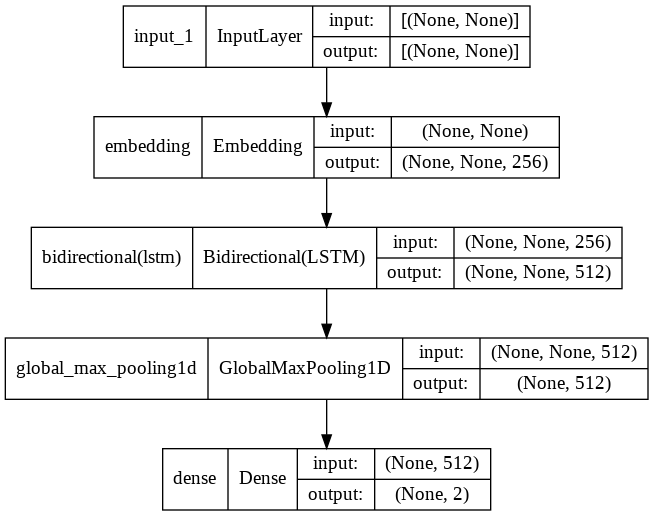

In [76]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [77]:
model.predict(train_inputs[:4])

array([[0.49607354, 0.50392646],
       [0.49654892, 0.5034511 ],
       [0.4986181 , 0.5013819 ],
       [0.49245253, 0.5075475 ]], dtype=float32)

In [78]:
model.predict(test_inputs[:4])

array([[0.49547645, 0.50452346],
       [0.49444693, 0.50555307],
       [0.49552745, 0.50447255],
       [0.4966304 , 0.5033695 ]], dtype=float32)

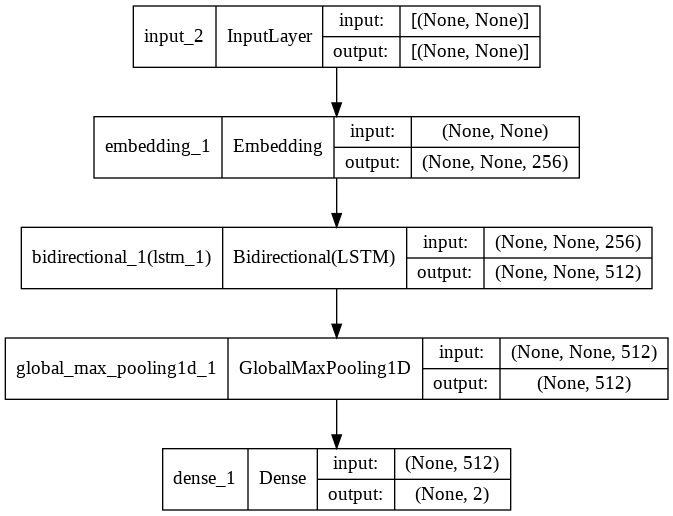

In [79]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [80]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])